In [1]:
!pip install qiskit
!pip install qiskit_aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 72.4 MB/s eta 0:00:00


Quantum Circuit:
     ┌───┐ ░           ┌────────┐          ┌────────┐                    »
q_0: ┤ H ├─░──■────────┤ P(1.9) ├─■────────┤ P(1.9) ├────────────────────»
     ├───┤ ░  │P(-3.8) ├────────┤ │        └────────┘          ┌────────┐»
q_1: ┤ H ├─░──■────────┤ P(1.9) ├─┼───────────────────■────────┤ P(1.9) ├»
     ├───┤ ░           └────────┘ │P(-3.8) ┌────────┐ │P(-3.8) ├────────┤»
q_2: ┤ H ├─░──────────────────────■────────┤ P(1.9) ├─■────────┤ P(1.9) ├»
     ├───┤ ░                               └────────┘          └────────┘»
q_3: ┤ H ├─░─────────────────────────────────────────────────────────────»
     ├───┤ ░                                                             »
q_4: ┤ H ├─░─────────────────────────────────────────────────────────────»
     └───┘ ░                                                             »
c: 5/════════════════════════════════════════════════════════════════════»
                                                                         »
«       

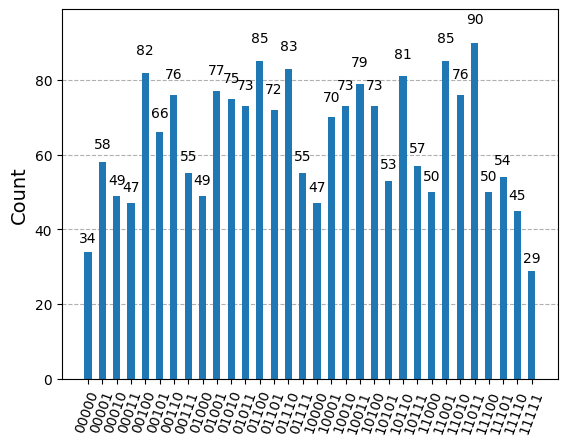

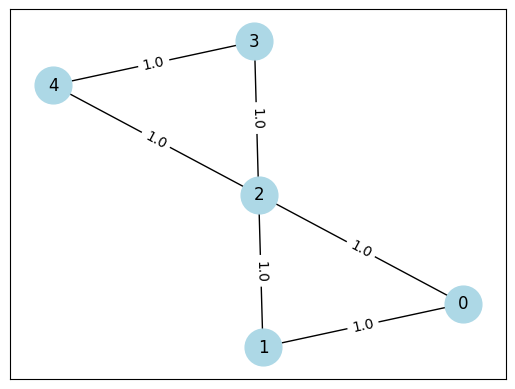

In [2]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


# Now we construct the graph with 5 nodes
n = 5
V = np.arange(0, n, 1)
E = [(0, 1, 1.0), (0, 2, 1.0), (1, 2, 1.0), (3, 2, 1.0), (3, 4, 1.0), (4, 2, 1.0)]
G = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)
#nx.draw_networkx(G)

# Draw the network with weights
pos = nx.spring_layout(G)  # Positioning of nodes
nx.draw_networkx(G, pos, with_labels=True, node_size=700, node_color="lightblue", font_size=12)

# Add the edge labels with weights
edge_labels = nx.get_edge_attributes(G, 'weight')  # Get the weights of the edges
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Classical Preprocessing, Determine angles
step_size = 0.1
a_gamma = np.arange(0, np.pi, step_size)
a_beta = np.arange(0, np.pi, step_size)
a_gamma, a_beta = np.meshgrid(a_gamma, a_beta)
F1 = 3 - (np.sin(2 * a_beta) ** 2 * np.sin(2 * a_gamma) ** 2 - 0.5 * np.sin(4 * a_beta) * np.sin(4 * a_gamma)) * (1 + np.cos(4 * a_gamma) ** 2)
result = np.where(F1 == np.amax(F1))
result[0] * 0.1
result[1] * 0.1
a = list(zip(result[0], result[1]))[0]
gamma = a[0] * step_size
beta = a[1] * step_size

# Prepare the quantum and classical registers
QAOA = QuantumCircuit(len(V), len(V))
# Apply the Hadamard gates to all qubits to have uniform superposition state
QAOA.h(range(len(V)))
QAOA.barrier()
# To implement U(C, gamma), apply below equivalent circuit
for edge in E:
    k = edge[0]
    l = edge[1]
    QAOA.cp(-2 * gamma, k, l)
    QAOA.p(gamma, k)
    QAOA.p(gamma, l)

# To implement U(B, beta), apply R_x(2*beta) to all qubits
QAOA.barrier()
QAOA.rx(2 * beta, range(len(V)))
# Measure the result in the computational basis
QAOA.barrier()
QAOA.measure(range(len(V)), range(len(V)))

shots = 2048

print("Quantum Circuit:")
print(QAOA)

# Use AerSimulator instead of IBM Q backend
simulator = AerSimulator()

# Transpile the circuit for the simulator
try:
    transpiled_qc = transpile(
        QAOA,
        simulator,
        optimization_level=2  # Set optimization level (0-3)
    )
    print("\nTranspilation successful!")
except Exception as e:
    print(f"Error during transpilation: {e}")
    raise

# Execute the transpiled circuit on the simulator
result = simulator.run(transpiled_qc, shots=shots).result()

# Get and display the results
counts = result.get_counts()
print("\nMeasurement Results:")
print(counts)

# Plot the results as a histogram
plot_histogram(counts)
